# Анализ A/B тестирования результатов скидок для сервисов "Жилая недвижимость"

- [Описание проекта](#project)
- [Сбор и подготовка данных](#data)
- [Подсчет метрик](#metrics)
- [Тестирование гипотез о разности параметров в группах A и B](#hypothesis)
    - [Конверсия](#convertion)
    - [Средний чек и ARPU](#aov_arpu)
- [Отчет](#total)


<a id="project"></a>
## Описание проекта

На сайте клининговой компании имеется сервис для владельцев жилой недвижимости, который предоставляет клининговые услуги по модели подписки (на месяц и на год), цены - 200 рублей и 1000 рублей соответственно. Продуктовая команда решила посмотреть каким образом скидки могли бы повлиять на аудиторию. Таким образом, было провелено A/B тестирование, при котором всех неплативших ранее и заходивших в период скидок пользователей поделили на группы А и В. Группе А не давали скидок, а группе В дали скидку 30%. 

Метрики, на которые влияют скидки: 
- ARPU 
- Конверсия 
- Средний чек (так как из-за скидок пользователи могли изменить структуру приобретения подписок)

Задача состоит в том, чтобы подвести итоги А/Б-тестирования, рассчитав, насколько в группах А и Б различаются вышеописанные метрики. 

Даты проведения тестирования: 2019-08-05 до 2019-08-11

ID теста: 127 

<b>Описание данных</b>
- ab_test_groups - в таблице представлены участники теста с разбивкой на группы
- payments - в таблице содежится информация о платежах этих пользователей за время теста



установка библиотеки в которой хранится метод для импорта файла из гугл диска

In [54]:
pip install GoogleDriveDownloader

Note: you may need to restart the kernel to use updated packages.


In [55]:
# Импорты нужных библиотек и функций

from google_drive_downloader import GoogleDriveDownloader as gdd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from statsmodels.stats import weightstats
from datetime import datetime
import statsmodels.stats.weightstats as ws
import math 


<a id="data"></a>
## Сбор и подготовка данных

In [56]:
# импорт файлов из гугл диска
gdd.download_file_from_google_drive(file_id='11YkCpuhJnWT_6qcnPaWduxLMkJKFJGyH',
                                    dest_path='./ab_test_groups.csv',
                                    unzip=True)

gdd.download_file_from_google_drive(file_id='1dkEJaheXKo4WBonsDpU_8NJA8WHg8Onm',
                                    dest_path='./payments.csv',
                                    unzip=True)


# сохраняем скаченные таблицы в датафреймы
ab_test_groups = pd.read_csv('ab_test_groups.csv')
ab_test_groups = ab_test_groups[ab_test_groups['ab_test_id']==127] # Так как ID нужного теста 127, выберем только такие строки.
payments = pd.read_csv('payments.csv')
print('ab_test_groups')
print(ab_test_groups.info())
display(ab_test_groups)
print(ab_test_groups.info())
print()
print('payments')
print(payments.info())
display(payments)




ab_test_groups
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153232 entries, 11999 to 165230
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     153232 non-null  int64 
 1   grp         153232 non-null  object
 2   ab_test_id  153232 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.7+ MB
None


,user_id,grp,ab_test_id
11999,1,B,127
12000,2,B,127
12001,3,B,127
12002,4,B,127
12003,5,A,127
...,...,...,...
165226,153228,A,127
165227,153229,B,127
165228,153230,B,127
165229,153231,B,127


<class 'pandas.core.frame.DataFrame'>
Int64Index: 153232 entries, 11999 to 165230
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     153232 non-null  int64 
 1   grp         153232 non-null  object
 2   ab_test_id  153232 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.7+ MB
None

payments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14639 entries, 0 to 14638
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   payment_id  14639 non-null  int64  
 1   user_id     14639 non-null  int64  
 2   price       14639 non-null  float64
 3   created_at  14639 non-null  object 
 4   tariff      14639 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 572.0+ KB
None


,payment_id,user_id,price,created_at,tariff
0,1,77831,200.0,2019-08-05 00:00:54,month
1,2,84576,200.0,2019-08-05 00:01:05,month
2,3,40981,140.0,2019-08-05 00:03:47,month_30off
3,4,130565,140.0,2019-08-05 00:09:33,month_30off
4,5,34758,700.0,2019-08-05 00:12:16,year_30off
...,...,...,...,...,...
14634,14635,9924,130.0,2019-08-18 22:54:57,month_35off
14635,14636,3722,650.0,2019-08-18 22:59:37,year_35off
14636,14637,5571,200.0,2019-08-18 23:02:54,month
14637,14638,11044,200.0,2019-08-18 23:13:54,month


ab_test_groups - таблица пользователей

- user_id	- идентификатор пользователя
- grp -	группа пользователя в А/В-тесте
- ab_test_id- идентификатор А/В-теста, в котором принимает участие пользователь

payments - таблица платежей

- payment_id - идентификатор платежа
- user_id - идентификатор пользователя
- price - цена товара
- created_at - дата размещения заказа 
- tariff - тариф или тип заказа


In [57]:
# так как дата создания заказа имеет тип object, переведем его в datetime
payments['created_at'] = pd.to_datetime(payments['created_at'])
print(payments.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14639 entries, 0 to 14638
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   payment_id  14639 non-null  int64         
 1   user_id     14639 non-null  int64         
 2   price       14639 non-null  float64       
 3   created_at  14639 non-null  datetime64[ns]
 4   tariff      14639 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 572.0+ KB
None


<a id="metrics"></a>
## Подсчет метрик

Название тарифа и дата совершения платежа не нужны для результатов А/В-теста. Поэтому нас будут интересовать только поля user_id и price. Также у нас ограничен период проведения теста — датами 2019-08-05 и 2019-08-11.

Выберем необходимые данные: проведём фильтрацию по дате через приведение столбца created_at к строковому типу данных. (Можно применять и другие подходы, но при таком формате данных такой способ самый простой.)

In [58]:
payments = payments[(payments['created_at']>='2019-08-05') & (payments['created_at']<'2019-08-12')][['user_id','price']]
payments




,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0
...,...,...
13701,2313,140.0
13702,139246,700.0
13703,42885,200.0
13704,129593,700.0


Как мы видим, данные устроены довольно просто: нам достаточно соединить эти две таблицы, чтобы осталась сводная информация обо всех участниках теста и покупках каждого из них за время теста.

In [59]:
# сгруппируем цену по юзер ид, так как у пользователя может быть несколько позиций покупок 
payments = payments.groupby(['user_id'], as_index = False)['price'].sum()
payments


,user_id,price
0,1,140.0
1,10,140.0
2,23,140.0
3,24,700.0
4,39,140.0
...,...,...
13701,153184,140.0
13702,153190,140.0
13703,153205,140.0
13704,153212,700.0


Cоединим эти две таблицы, чтобы осталась сводная информация обо всех участниках теста и покупках каждого из них за время теста.

In [60]:
ab_data = ab_test_groups.merge(payments, on = 'user_id', how = 'left')
ab_data


,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN
...,...,...,...,...
153227,153228,A,127,NaN
153228,153229,B,127,NaN
153229,153230,B,127,NaN
153230,153231,B,127,NaN


посмотрим, в каких пропорциях разбиты пользователи на группы и какое количество пользователей в каждой группе что-то купило:

In [61]:
ab_summary = ab_data.groupby(['grp'], as_index = False)[['user_id','price']].count()
ab_summary = ab_summary.rename(columns={'user_id':'users_count', 'price':'buyers_count'})
ab_summary



,grp,users_count,buyers_count
0,A,76605,4279
1,B,76627,9427


Посчитаем долю пользователей в каждой группе

In [62]:
ab_summary['users_count_share'] = ab_summary['users_count']/ab_summary['users_count'].sum()
ab_summary['buyers_count_share'] = ab_summary['buyers_count']/ab_summary['buyers_count'].sum()
ab_summary['conversion'] = (ab_summary['buyers_count'] / ab_summary['users_count'])
ab_summary


,grp,users_count,buyers_count,users_count_share,buyers_count_share,conversion
0,A,76605,4279,0.499928,0.312199,0.055858
1,B,76627,9427,0.500072,0.687801,0.123025


Как мы видим, в обоих группах по 50% пользователей, из чего можем сделать вывод, что использована разбивка 50/50. При этом количество покупателей существенно различается (в группе B покупателей больше чем в группе A более чем в два раза).
Конверсия также серьёзно различается: в первой группе она составляет 5,6 %, а во второй — 12,3 %


посчитаем средний чек покупки в каждой группе

In [63]:
ab_summary = ab_summary.merge(ab_data.groupby(['grp'],as_index = False)['price'].mean().rename(columns = {'price':'avg_bill'}), 
                on = 'grp', how='left')

ab_summary


,grp,users_count,buyers_count,users_count_share,buyers_count_share,conversion,avg_bill
0,A,76605,4279,0.499928,0.312199,0.055858,396.120589
1,B,76627,9427,0.500072,0.687801,0.123025,348.804498


Несмотря на то что скидка в группе Б составляет 30%, средний чек упал на ~12%.
Осталось подсчитать ARPU пользователей (среднюю выручку на пользователя в группе), а также дополнительную выручку, которую принесла группа Б.


Дополнительная выручка — это выручка, которую пользователи принесли дополнительно, если считать базовой выручку всех пользователей с ARPU, равным ARPU в контрольной группе.


In [64]:
# Считаем общих доход
ab_summary = ab_summary.merge(ab_data.groupby(['grp'], as_index = False)['price'].sum().rename(columns = {'price':'revenue'}), 
                 on='grp', how='left')
ab_summary.set_index('grp', drop=True)
ab_summary



,grp,users_count,buyers_count,users_count_share,buyers_count_share,conversion,avg_bill,revenue
0,A,76605,4279,0.499928,0.312199,0.055858,396.120589,1695000.0
1,B,76627,9427,0.500072,0.687801,0.123025,348.804498,3288180.0


In [65]:
# считаем arpu
ab_summary['ARPU'] = ab_summary['revenue']/ab_summary['users_count']
ab_summary = ab_summary.set_index('grp', drop=True)
ab_summary


,users_count,buyers_count,users_count_share,buyers_count_share,conversion,avg_bill,revenue,ARPU
grp,,,,,,,,
A,76605,4279,0.499928,0.312199,0.055858,396.120589,1695000.0,22.126493
B,76627,9427,0.500072,0.687801,0.123025,348.804498,3288180.0,42.911506


In [66]:
# считаем дополнительную выручку
ab_summary['Доп. выручка'] = ab_summary['users_count']*(ab_summary['ARPU'] - ab_summary.loc['A', 'ARPU'])


ab_summary


,users_count,buyers_count,users_count_share,buyers_count_share,conversion,avg_bill,revenue,ARPU,Доп. выручка
grp,,,,,,,,,
A,76605,4279,0.499928,0.312199,0.055858,396.120589,1695000.0,22.126493,0.000000e+00
B,76627,9427,0.500072,0.687801,0.123025,348.804498,3288180.0,42.911506,1.592693e+06


<a id="hypothesis"></a>
## Тестирование гипотез о разности параметров в группах A и B


<a id="convertion"></a>
###  Конверсия 

Рассчитаем значимость изменения конверсии.

<b>Постановка гипотезы</b>
- H0: конверсия в группе А = конверсия в группе В (или конверсия А - конверсия В = 0)
- H1: конверсия в группе А < конверсия в группе В (конверсия А - конверсия В < 0) - т.е уровень конверсии вырос 

<b>Наблюдения</b>
- выборочная конверсия в группе А = 0.055858,   количество пользователей в группе А = 76605
- выборочная конверсия в группе В = 0.123025,   количество пользователей в группе В = 76627

Если гипотеза H0 верна, тогда разность выборочных конверсий (или по-другому пропорций) распределена нормально (по ЦПТ при достаточно большом n выборки пропорция распределена нормально) с матожиданием равным нулю и известным стандартным отклонением. 
Исходя из этого мы можем найти z статистику и соответствующее p-value. 

В качестве уровня значимости альфа возьмем 0,05. 


In [67]:
z_test = ztest(ab_data.loc[ab_data.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0),#Конверсии пользователей группы А
     ab_data.loc[ab_data.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0) #Конверсии пользователей группы B
     ) 

print(' z статистика =', z_test[0], '\n', 'p-value =', z_test[1])



 z статистика = -46.38627328408593 
 p-value = 0.0


Таким образом, если H0 выполняется, то в данном случае вероятность получить наши наблюдаемые результаты настолько мала (значение p-value = 0.0 и явно меньше 0.05), что позволяет говорить о фактическом улучшении конверсии в группе В, то есть после введения скидки 30%. 







<a id="aov_arpu"></a>
### Средний чек и ARPU

Теперь рассмотрим различия среднего чека и ARPU.



#### Проверка распределения на нормальность, тест Шапиро-Вилка

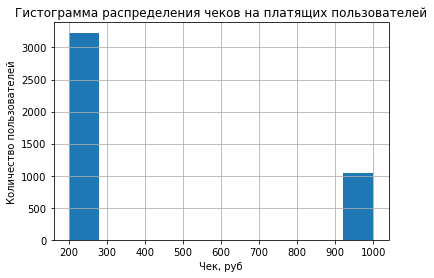

Shapiro-Wilk p-value is 0.0


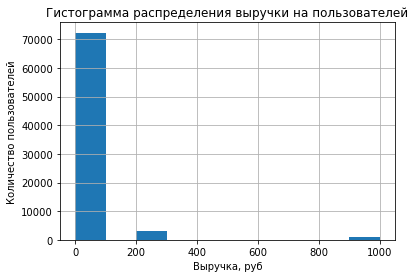

Shapiro-Wilk p-value is 0.0


/Users/lxndrarura/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [68]:
ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].dropna())[1])

ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0))[1])


    

И визуальный анализ, и тест Шапиро-Вилка на нормальность говорят нам, что распределение не является нормальным (stats.shapiro выдаёт два числа, второе — p-значение сравнения нормального распределения и нашего).


#### Тест Стьюдента и U-тест Манна-Уитни

Так как распределения признаков не бинарные (0-1) и не нормальные, нужно использовать для сравнения средних не только T-тест, но и непараметрический U-тест Манна-Уитни. Несмотря на ненормальность распределения, в силу действия ЦПТ мы можем использовать Т-тест. 


U-тест сообщит, различаются ли сами распределения, а T-тест покажет, различаются ли средние этих распределений. При сравнении средних величин (например, ARPU) обычно важнее показатель p-значение для Т-теста: если он меньше 0,05, а p-значение теста Манна-Уитни больше 0,05, то это всё равно говорит о значимых различиях показателей.

#### Сравнение среднего чека

<b>Постановка гипотезы</b>
- H0: средний чек в группе А = средний чек в группе В (или средний чек А - средний чек В = 0)
- H1: средний чек в группе A > средний чек в группе B (средний чек A - средний чек B > 0) - т.е средний чек в В упал 

<b>Наблюдения</b>
- выборочное среднее чека в группе А = 396.12
- выборочное среднее чека в группе В = 348.8
- Нет оснований полагать, что истинные стандартные отклонения чека в A и B равны. 

Если гипотеза H0 верна, тогда разность выборочных средних чека распределена нормально с истинным матожиданием равным нулю и неизвестным нам истинным стандартным отклонением(по ЦПТ при достаточно большом n выборки ее выборочное среднее распределено нормально). 
Исходя из этого мы можем найти t статистику и соответствующее p-value. Также дополнительно проводим U-тест.

В качестве уровня значимости альфа возьмем 0,05. 




In [69]:
# СРЕДНИЙ ЧЕК

# alternative='greater' потому что альтернативная гипотеза H1 звучит как 
# "разность средних значений чеков А и В БОЛЬШЕ чем ноль"
u_result_bill = stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(0), ab_data.loc[ab_data.grp == 'B', 'price'].dropna(0), 
                              alternative='greater')

# usevar='unequal' потому чтро нет оснований полагать, что истинные средние отклонения в А и В равны 
# alternative='larger' потому что альтернативная гипотеза H1 звучит как 
# "разность средних значений чеков А и В БОЛЬШЕ чем ноль"
t_result_bill = weightstats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(0), ab_data.loc[ab_data.grp == 'B', 'price'].dropna(0),
                     usevar='unequal', alternative='larger')

print(u_result_bill)
print('Ttest_indResult', t_result_bill[0], '{:.19f}'.format(t_result_bill[1]))



MannwhitneyuResult(statistic=28984683.0, pvalue=0.0)
Ttest_indResult 7.945395534593604 0.0000000000000011253


Оба теста показали очень маленькое p-value, гораздо меньшее чем 0.05 (0.0 у Манна-Уитни и 0.0000000000000011253 у Стьюдента), что говорит о том, что если бы истинные матожидания чеков в А и В были бы равны, то вероятность получить наши наблюдаемые выборочные значения среднего чека была бы очень сильно мала, поэтому мы отвергаем нулевую гипотезу о равенстве средних чеков в пользу альтернативной и считаем, что средний чек в А действительно значимо больше чем в В.





#### Сравнение ARPU

<b>Постановка гипотезы</b>
- H0: ARPU в группе А = ARPU в группе В (или ARPU А - ARPU В = 0)
- H1: ARPU в группе A < ARPU в группе B (средний чек A - средний чек B < 0) - т.е ARPU в В выросло

<b>Наблюдения</b>
- выборочное ARPU в группе А = 22.13
- выборочное ARPU в группе В = 42.91
- Нет оснований полагать, что истинные стандартные отклонения доходов с каждого пользователя в A и B равны. 

Если гипотеза H0 верна, тогда разность выборочных ARPU в А и В распределена нормально с истинным матожиданием равным нулю и неизвестным нам истинным стандартным отклонением(по ЦПТ при достаточно большом n выборки ее выборочное среднее распределено нормально). 
Исходя из этого мы можем найти t статистику и соответствующее p-value. Также дополнительно проводим U-тест

В качестве уровня значимости альфа возьмем 0,05. 



In [70]:
# ARPU

# alternative='less' потому что альтернативная гипотеза H1 звучит как 
# "разность ARPU А и В МЕНЬШЕ чем ноль"
u_result_arpu = stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0), 
                              alternative='less')

# usevar='unequal' потому чтро нет оснований полагать, что истинные средние отклонения в А и В равны 
# alternative='smaller' потому что альтернативная гипотеза H1 звучит как 
# "разность ARPU А и В МЕНЬШЕ чем ноль"
t_result_arpu = weightstats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0),
                     usevar='unequal', alternative='smaller')

print(u_result_arpu)
print('Ttest_indResult', t_result_arpu[0], '{:.19f}'.format(t_result_arpu[1]))


MannwhitneyuResult(statistic=2746687083.0, pvalue=0.0)
Ttest_indResult -29.894186199299803 0.0000000000000000000


Оба теста показали очень маленькое p-value, гораздо меньшее чем 0.05, что говорит о том, что если бы истинные матожидания дохода с каждого пользователя в А и В были бы равны, то вероятность получить наши наблюдаемые выборочные ARPU была бы очень сильно мала, поэтому мы отвергаем нулевую гипотезу о равенстве ARPU в А и В и считаем, что ARPU в B действительно значимо больше чем в A.

## Доверительные интервалы 

Посчитаем доверительные интервалы для конверсии, arpu и среднего чека. 


In [71]:
#Функции для получения доверительных интервалов

# Считает доверительные интервалы для средних
def get_conf_interval(data, conf_level = 0.95):  
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        # возвращаем предел погрешности
        return (buf[1] - buf[0])/2
    
#Считает доверительные интервалы для бинарных величин
def get_conf_interval_z(succ, tot):  
    buf = proportion_confint(succ, tot)
    # возвращаем предел погрешности
    return buf[1] - buf[0]



In [72]:
# Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {
    'ARPU': {'A': get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)) ,
            'B': get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0)) },
    'avg_bill': {'A': get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(0)), 
                'B': get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna(0)) },
    'conversion': {'A': get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(0).count(), 
                                            ab_data.loc[ab_data.grp == 'A', 'user_id'].count()),
                  'B': get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna(0).count(), 
                                            ab_data.loc[ab_data.grp == 'B', 'user_id'].count())}
}


conf_intervals


{'ARPU': {'A': 0.8641428736438357, 'B': 1.0537383983825563},
 'avg_bill': {'A': 10.315428393735829, 'B': 5.467446406040892},
 'conversion': {'A': 0.0032524511174824022, 'B': 0.004651325604805509}}

Группа А: 
- ARPU = (22.12 - 0.86; 22.12 + 0.86)
- Средний чек = (396.12 - 10.32; 396.12 + 10.32)
- Конверсия = (0.056 - 0.003; 0.56 + 0.003)

Группа B:
- ARPU = (42.91 - 1.05; 42.91 + 1.05)
- Средний чек = (348.8 - 5.47; 348.8 + 5.47)
- Конверсия = (0.12 - 0.005; 0.12 + 0.005)


<a id="total"></a>
# Отчет

In [73]:
# Удобная функция для подстановки подписей на barplot

# Расставляет подписи столбцов на барплоты
def set_labels(axes):
    # Размер графика по оси Y
    y0, y1 = axes.get_ybound()  
    #Дополнительное место под надписи
    y_shift = 0.15* (y1 - y0)  

    # По всем нарисованным прямоугольникам
    for i, rect in enumerate(axes.patches):  
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
                #Посередине прямоугольника
        x = rect.get_x() + rect.get_width() / 2
        #Над прямоугольником в середине доп. места
        y = height + y_shift * 0.8  
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [74]:
#Транспонированная таблица для удобства использования
plot_summary = ab_summary.T 
#Метрики со статзначимыми различиями
significant_changes = ['conversion', 'avg_bill', 'ARPU'] 
plot_summary


grp,A,B
users_count,7.660500e+04,7.662700e+04
buyers_count,4.279000e+03,9.427000e+03
users_count_share,4.999282e-01,5.000718e-01
buyers_count_share,3.121990e-01,6.878010e-01
conversion,5.585797e-02,1.230245e-01
avg_bill,3.961206e+02,3.488045e+02
revenue,1.695000e+06,3.288180e+06
ARPU,2.212649e+01,4.291151e+01
Доп. выручка,0.000000e+00,1.592693e+06


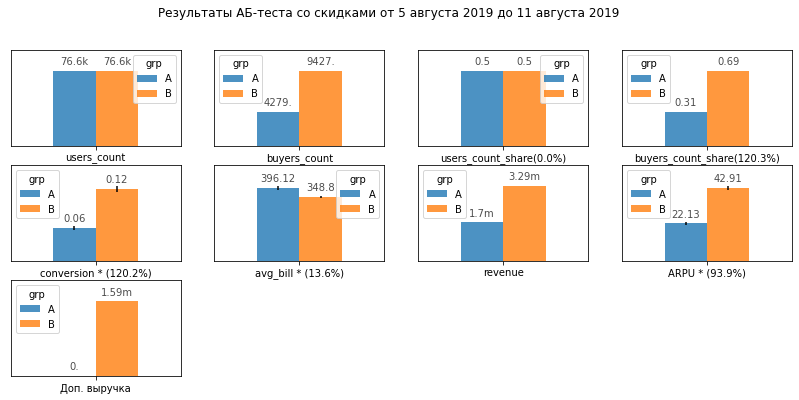

In [75]:
from matplotlib import gridspec
from math import ceil

# Массив для складирования графиков
ax = []
# Количество картинок в одной линии
n_pict_in_line = 4

# Создаём сетку для графиков
gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line)
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row and "Доп. выручка" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста со скидками от 5 августа 2019 до 11 августа 2019')

## Строим графики
for i, col in enumerate(plot_summary.index):
    # Добавляем subplot в нужную клетку
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line]))
    # Строим график в нужной клетке
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8,
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) # yerr для отображения доверительного интервала на грифике (черная полосочка)

    
# Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий    
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[i].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[i].set_xticklabels(ticks)
    ax[i].set_yticks([])
    # добавляем подписи к столбцам
    set_labels(axes=ax[i])


В данном случае все полученные интересующие нас результаты показали статистически значимые результаты.

- ARPU значимо вырос на 93.9%.
- Конверсия значимо увеличилась на 120.2%.
- Средний чек значимо упал на 13,6%.

<b>Рекомендации</b>: 
- Можно проверить влияние размера скидки, чтобы найти максимально эффективную стратегию. Скидки можно подбирать и на основе какой-то модели (например, наиболее давним и лояльным пользователям давать более глубокие скидки), эффективность которой можно также сравнить со скидками.
- В целом, скидки способствуют мгновенному увеличению выручки, поэтому их можно проводить время от времени. Через месяц можно будет посмотреть на этих же пользователей, чтобы узнать, больше ли приносят продления по сравнению с «нескидочными» пользователями.

